<a href="https://colab.research.google.com/github/Amlan05/EquityMeanReversion/blob/main/Stragegy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/sbi_life_daily.xlsx'

In [ ]:
data = pd.read_excel(file_path, sheet_name=1, engine='openpyxl')

In [ ]:
data = data[::-1]


In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

In [ ]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-20,222.48,245.85,215.75,219.93,6430036
2020-01-21,219.85,219.85,212.62,214.10,353956
2020-01-22,214.00,215.85,210.62,212.88,897394
2020-01-23,211.52,214.00,196.50,201.82,5804348
2020-01-24,200.00,202.00,195.15,198.32,618194


In [ ]:
# RSI Calculation
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)


In [ ]:
# MACD Calculation
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

In [ ]:
# Calculate True Range (TR)
data['Previous_Close'] = data['Close'].shift(1)
data['True_Range'] = data[['High', 'Low', 'Close', 'Previous_Close']].apply(
    lambda row: max(
        row['High'] - row['Low'],
        abs(row['High'] - row['Previous_Close']),
        abs(row['Low'] - row['Previous_Close'])
    ), axis=1
)

# Calculate ATR (14-period rolling mean of True Range)
data['ATR'] = data['True_Range'].rolling(window=14).mean()



In [ ]:
# Bollinger Bands
data['50_MA'] = data['Close'].rolling(window=50).mean()
data['50_STD'] = data['Close'].rolling(window=50).std()
data['Upper_BB'] = data['50_MA'] + (2 * data['50_STD'])
data['Lower_BB'] = data['50_MA'] - (2 * data['50_STD'])

In [ ]:
# Moving Averages
data['100_MA'] = data['Close'].rolling(window=100).mean()
data['20_MA'] = data['Close'].rolling(window=20).mean()

# Relative Volume
data['Average_Volume'] = data['Volume'].rolling(window=20).mean()
data['RVOL'] = data['Volume'] / data['Average_Volume']

In [ ]:
# Price Action Logic
def detect_price_action(row):
    body = abs(row['Close'] - row['Open'])
    wick_up = row['High'] - max(row['Close'], row['Open'])
    wick_down = min(row['Close'], row['Open']) - row['Low']

    if wick_up > 2 * body and wick_down < body and row['Close'] < row['Open']:
        return 'Shooting Star'
    elif wick_down > 2 * body and wick_up < body and row['Close'] > row['Open']:
        return 'Hammer'
    elif body > wick_up + wick_down and row['RVOL'] > 1:
        if row['Close'] < row['Open']:
            return 'Large Body Down'
        elif row['Close'] > row['Open']:
            return 'Large Body Up'
    return None

data['Price_Action'] = data.apply(detect_price_action, axis=1)


In [ ]:
!pip install openpyxl

In [ ]:
def detect_volume_spike(row, previous_row):
    if row['Volume'] > 2 * row['Average_Volume']:  # Sudden spike
        if previous_row['Volume'] > row['Volume']:  # Volume decrease after spike
            return 'False Breakout'
        elif row['RVOL'] > 1:  # Good volume after spike
            return 'Valid Breakout'
    return None

data['Volume_Spike'] = data.apply(
    lambda row: detect_volume_spike(row, data.shift(1).loc[row.name]), axis=1
)

In [ ]:
position = 0
entry_price = None
stop_loss_price = None
above_ma_volume_counter = 0

In [ ]:
data['Buy_Date'] = None
data['Sell_Date'] = None
data['Stop_Loss'] = None

In [ ]:
action = input("Enter the action (buy or sell): ").strip().lower()
trade_date = input("Enter the trade date (YYYY-MM-DD): ")

Enter the action (buy or sell): buy
Enter the trade date (YYYY-MM-DD): 2020-03-31


In [ ]:
entry_row = data.loc[data.index == pd.to_datetime(trade_date)]
if not entry_row.empty:
    print(f"ATR on Entry Date ({trade_date}): {entry_row['ATR'].iloc[0]}")
else:
    print(f"No data found for entry date: {trade_date}")

ATR on Entry Date (2020-03-31): 18.802142857142854


In [ ]:
data['Rolling_Volume_Mean'] = data['Volume'].rolling(window=20).mean()

# Backtesting Logic
for index, row in data.iterrows():
    if position == 0 and str(index.date()) == trade_date:
        entry_atr = row['ATR']
        if action == "buy":
            entry_price = row['Close']
            stop_loss_price = entry_price - 1.5 * entry_atr
            position = 1
            data.at[index, 'Buy_Date'] = entry_price
            data.at[index, 'Stop_Loss'] = stop_loss_price
        elif action == "sell":
            entry_price = row['Close']
            stop_loss_price = entry_price + 1.5 * entry_atr
            position = -1
            data.at[index, 'Sell_Date'] = entry_price
            data.at[index, 'Stop_Loss'] = stop_loss_price
    elif position != 0:
        if position == 1:
            if row['Close'] <= stop_loss_price:
                position = 0
                entry_price = None
                stop_loss_price = None
                above_ma_volume_counter = 0
                data.at[index, 'Sell_Date'] = row['Close']
            elif row['Close'] > row['100_MA']:
                if row['Volume'] > data.at[index, 'Rolling_Volume_Mean']:
                    above_ma_volume_counter += 1
                else:
                    above_ma_volume_counter = 0
                if above_ma_volume_counter == 2:
                    position = 0
                    entry_price = None
                    stop_loss_price = None
                    above_ma_volume_counter = 0
                    data.at[index, 'Sell_Date'] = row['Close']
        elif position == -1:
            if row['Close'] >= stop_loss_price:
                position = 0
                entry_price = None
                stop_loss_price = None
                above_ma_volume_counter = 0
                data.at[index, 'Buy_Date'] = row['Close']
            elif row['Close'] < row['100_MA']:
                if row['Volume'] > data.at[index, 'Rolling_Volume_Mean']:  # High volume
                    above_ma_volume_counter += 1
                else:
                    above_ma_volume_counter = 0
                if above_ma_volume_counter == 2:
                    position = 0
                    entry_price = None
                    stop_loss_price = None
                    above_ma_volume_counter = 0
                    data.at[index, 'Buy_Date'] = row['Close']  # Exit for short


In [ ]:
# Filter data for the trade timeframe
trade_start_date = pd.to_datetime(trade_date)
trade_end_date = data.loc[data['Sell_Date'].notnull()].index.max()


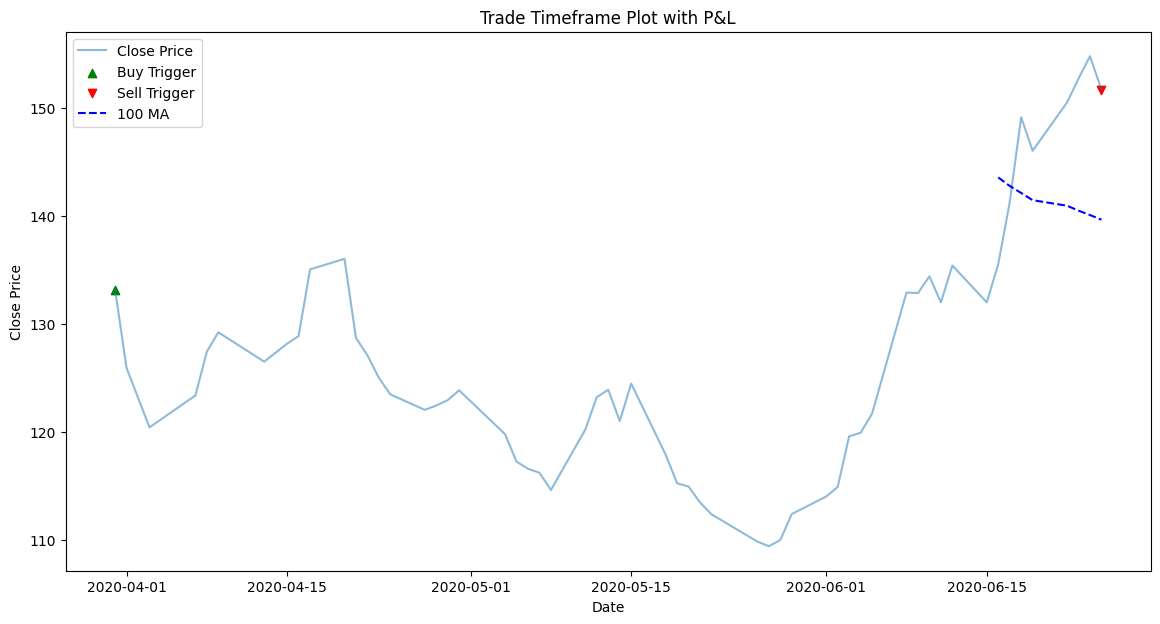

Entry Price: 133.18
Exit Price: 151.7
Exit Date: 2020-06-25
Profit or Loss for the trade: +18.52


In [ ]:
if trade_end_date is None or trade_end_date < trade_start_date:
    trade_end_date = data.index[-1]  # Use the last date in the dataset if no sell occurred or invalid end date

trade_data = data[(data.index >= trade_start_date) & (data.index <= trade_end_date)]

if trade_data.empty:
    print("No data available for the specified trade timeframe. Please check your inputs.")
else:
    plt.figure(figsize=(14, 7))
    plt.plot(trade_data.index, trade_data['Close'], label='Close Price', alpha=0.5)
    plt.scatter(trade_data.index, trade_data['Buy_Date'], label='Buy Trigger', marker='^', color='green')
    plt.scatter(trade_data.index, trade_data['Sell_Date'], label='Sell Trigger', marker='v', color='red')
    plt.plot(trade_data.index, trade_data['100_MA'], label='100 MA', linestyle='--', color='blue')
    plt.legend()
    plt.title('Trade Timeframe Plot with P&L')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    # Calculate Profit or Loss
    if position == 0:
        buy_row = data.loc[data['Buy_Date'].notnull()]
        sell_row = data.loc[data['Sell_Date'].notnull()]

        if not buy_row.empty and not sell_row.empty:
            buy_price = buy_row['Buy_Date'].iloc[0]
            sell_price = sell_row['Sell_Date'].iloc[0]
            exit_date = sell_row.index[0].strftime('%Y-%m-%d')
            profit_loss = sell_price - buy_price if action == "buy" else buy_price - sell_price
            profit_loss = round(profit_loss, 2)

            print(f"Entry Price: {buy_price}")
            print(f"Exit Price: {sell_price}")
            print(f"Exit Date: {exit_date}")
            print(f"Profit or Loss for the trade: {'+' if profit_loss > 0 else ''}{profit_loss}")
        else:
            print("No valid buy or sell points found in the data.")
    else:
        print("The trade is still open. No P&L calculated.")
